<a href="https://colab.research.google.com/github/Ignaciogg1/Challenguer2telecom/blob/main/Copia_de_Copia_de_ChallengerTelecomx2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import pandas as pd

# Importar archivo CSV
df = pd.read_csv("/content/df_flat")

# Mostrar primeras filas
print(df.head())

   customerID Churn  gender  SeniorCitizen Partner Dependents  tenure  \
0  0002-ORFBO    No  Female              0     Yes        Yes       9   
1  0003-MKNFE    No    Male              0      No         No       9   
2  0004-TLHLJ   Yes    Male              0      No         No       4   
3  0011-IGKFF   Yes    Male              1     Yes         No      13   
4  0013-EXCHZ   Yes  Female              1     Yes         No       3   

  PhoneService MultipleLines InternetService  ... TechSupport StreamingTV  \
0          Yes            No             DSL  ...         Yes         Yes   
1          Yes           Yes             DSL  ...          No          No   
2          Yes            No     Fiber optic  ...          No          No   
3          Yes            No     Fiber optic  ...          No         Yes   
4          Yes            No     Fiber optic  ...         Yes         Yes   

  StreamingMovies        Contract PaperlessBilling     PaymentMethod  \
0              No        O

In [ ]:

# 1. Eliminar columna ID
df = df.drop("customerID", axis=1)

# 2. One-Hot Encoding (convierte categóricas a dummies)
df_encoded = pd.get_dummies(df, drop_first=True)

# Mostrar las primeras filas
print(df_encoded.head())

   SeniorCitizen  tenure  Charges.Monthly  cuentas_diarias  total_servicios  \
0              0       9             65.6             2.19                4   
1              0       9             59.9             2.00                3   
2              0       4             73.9             2.46                2   
3              1      13             98.0             3.27                5   
4              1       3             83.9             2.80                3   

   Churn_Yes  gender_Male  Partner_Yes  Dependents_Yes  PhoneService_Yes  ...  \
0      False        False         True            True              True  ...   
1      False         True        False           False              True  ...   
2       True         True        False           False              True  ...   
3       True         True         True           False              True  ...   
4       True        False         True           False              True  ...   

   Charges.Total_995.35  Charges.Total

Conteo de clientes:
 Churn
No     5174
Yes    1869
Name: count, dtype: int64

Proporción de clientes:
 Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


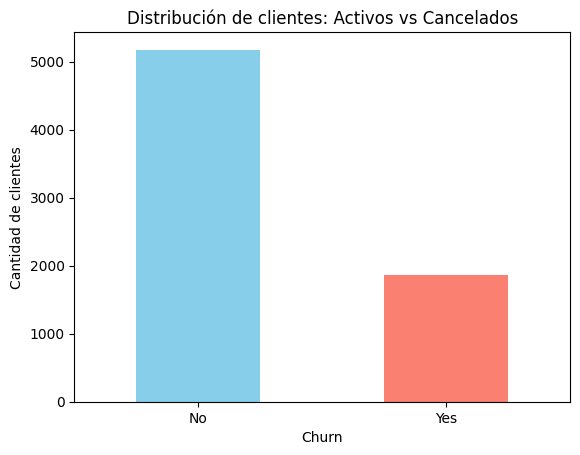

In [ ]:

# Distribución de la variable objetivo Churn
churn_counts = df["Churn"].value_counts()
churn_ratio = df["Churn"].value_counts(normalize=True)

print("Conteo de clientes:\n", churn_counts)
print("\nProporción de clientes:\n", churn_ratio)

# Opcional: visualización rápida
import matplotlib.pyplot as plt

churn_counts.plot(kind="bar", color=["skyblue", "salmon"])
plt.title("Distribución de clientes: Activos vs Cancelados")
plt.ylabel("Cantidad de clientes")
plt.xticks(rotation=0)
plt.show()



Interpretación esperada:

No (activos): ~73%

Yes (cancelaron): ~27%


   Esto significa que sí existe desbalance de clases, ya que la clase mayoritaria (clientes activos) es casi el triple de la minoritaria (cancelados).
Este desbalance puede impactar en los modelos predictivos, por ejemplo:

Un modelo trivial que prediga siempre "No churn" tendría ~73% de accuracy sin realmente aprender nada.

Debemos separar variables predictoras (X) y variable objetivo (y):

In [ ]:
from sklearn.model_selection import train_test_split

# Variable objetivo
y = df_encoded["Churn_Yes"].astype(int)  # convert boolean to 0 and 1
# Variables predictoras (ejemplo, eliminamos customerID)
X = df_encoded.drop(columns=["Churn_Yes"])

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Proportion original in train:")
print(y_train.value_counts(normalize=True))

Proportion original in train:
Churn_Yes
0    0.742823
1    0.257177
Name: proportion, dtype: float64


Undersampling (submuestreo de la clase mayoritaria)

Reduce el número de ejemplos de la clase mayoritaria para balancear

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

print("\nProporción tras undersampling:")
print(y_train_under.value_counts(normalize=True))


Proporción tras undersampling:
Churn_Yes
0    0.5
1    0.5
Name: proportion, dtype: float64


 Oversampling (sobremuestreo de la clase minoritaria)

Duplica ejemplos de la clase minoritaria

In [ ]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(random_state=42)
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)

print("\nProporción tras oversampling:")
print(y_train_over.value_counts(normalize=True))


Proporción tras oversampling:
Churn_Yes
0    0.5
1    0.5
Name: proportion, dtype: float64


SMOTE (Synthetic Minority Oversampling Technique)

Genera ejemplos sintéticos de la clase minoritaria en lugar de duplicar

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nProporción tras SMOTE:")
print(y_train_smote.value_counts(normalize=True))


Proporción tras SMOTE:
Churn_Yes
0    0.5
1    0.5
Name: proportion, dtype: float64


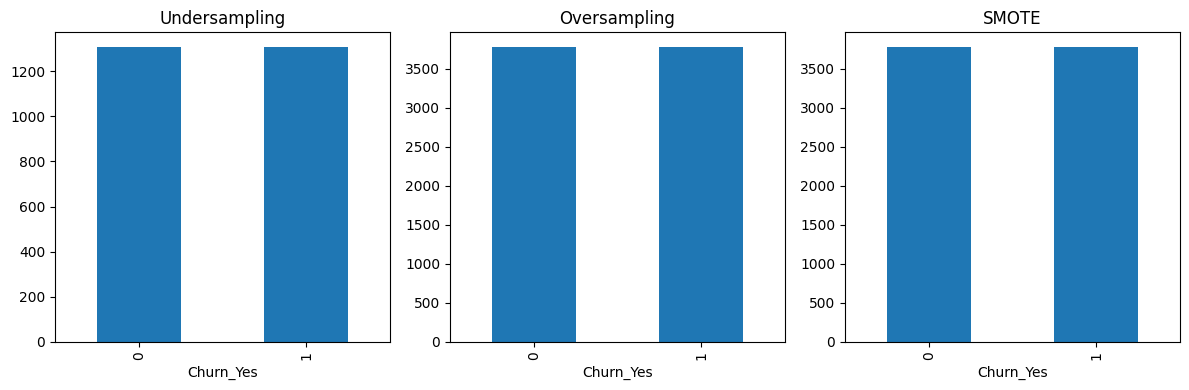

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(12,4))

y_train_under.value_counts().plot(kind="bar", ax=axs[0], title="Undersampling")
y_train_over.value_counts().plot(kind="bar", ax=axs[1], title="Oversampling")
y_train_smote.value_counts().plot(kind="bar", ax=axs[2], title="SMOTE")

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Modelo sensible a escala (KNN) → requiere estandarización
pipeline_knn = Pipeline([
    ("scaler", StandardScaler()),   # normalización
    ("knn", KNeighborsClassifier(n_neighbors=5))
])

# Modelo no sensible a escala (Random Forest) → sin estandarización
pipeline_rf = Pipeline([
    ("rf", RandomForestClassifier(n_estimators=100, random_state=42))
])

¿Cuándo normalizar o estandarizar?

Modelos sensibles a la escala (sí requieren normalización/estandarización):

KNN (K-Nearest Neighbors) → La distancia euclidiana se distorsiona si no escalas.

SVM (Support Vector Machine) → El cálculo de hiperplanos depende de magnitudes de los vectores.

Regresión Logística → Los coeficientes se ven afectados si las variables están en escalas muy distintas.

Redes Neuronales (ANN, Deep Learning) → Convergencia del gradiente más rápida y estable si los datos están estandarizados.


➡️ Recomendación: aplicar StandardScaler (media=0, var=1) o MinMaxScaler (0–1).


---

Modelos no sensibles a la escala:

Decision Tree

Random Forest

XGBoost / LightGBM / CatBoost


Estos algoritmos usan divisiones basadas en umbrales y ganancia de información, por lo que la escala de las variables no afecta su desempeño.

➡️ Recomendación: NO necesitas normalizar ni estandarizar para estos modelos.


🔹Conclusión

Si vas a probar modelos basados en distancia o gradiente (KNN, SVM, Regresión Logística, Redes Neuronales) 👉 sí o sí aplicar normalización/estandarización.

Si usas modelos basados en árboles (Decision Tree, Random Forest, XGBoost) 👉 no es necesario.

In [ ]:
import pandas as pd

# Convertir variable objetivo a numérica
df["Churn_num"] = df["Churn"].map({"No": 0, "Yes": 1})

# Seleccionar solo variables numéricas (incluyendo Churn_num)
df_num = df.select_dtypes(include=["int64", "float64", "bool"])

In [ ]:

# Matriz de correlación
corr_matrix = df_num.corr()

# Correlación de cada variable con la cancelación
corr_churn = corr_matrix["Churn_num"].sort_values(ascending=False)

print("Correlación con la variable Churn:\n")
print(corr_churn)

Correlación con la variable Churn:

Churn_num          1.000000
cuentas_diarias    0.193412
Charges.Monthly    0.193356
SeniorCitizen      0.150889
total_servicios   -0.067264
tenure            -0.352229
Name: Churn_num, dtype: float64


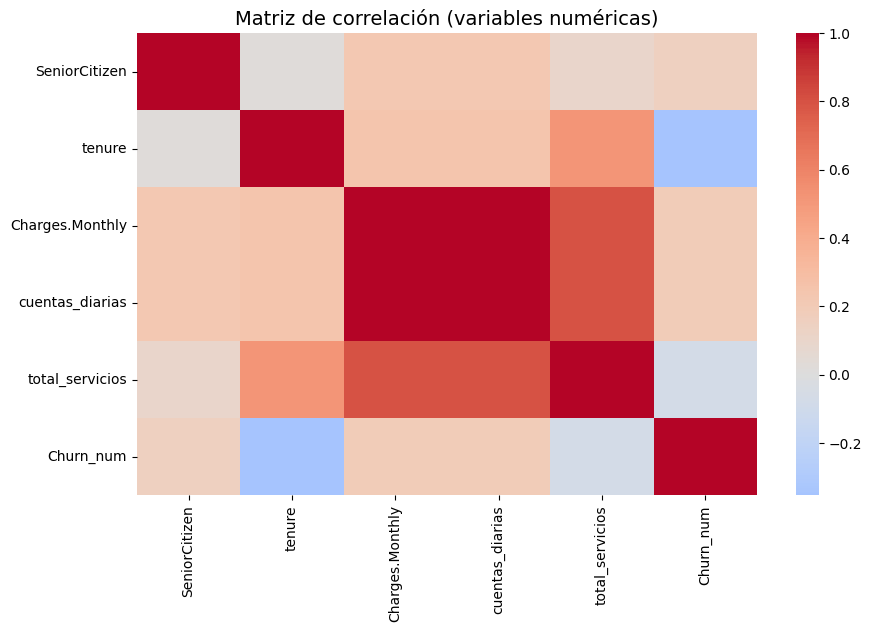

In [ ]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(
    corr_matrix,
    annot=False,
    cmap="coolwarm",   # ← aquí es cmap, no palette
    center=0
)
plt.title("Matriz de correlación (variables numéricas)", fontsize=14)
plt.show()

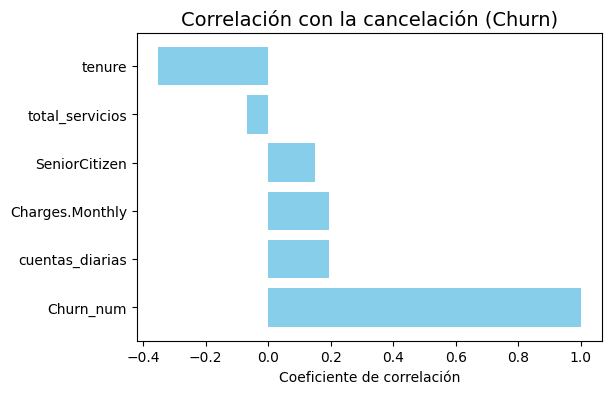

In [ ]:
plt.figure(figsize=(6,4))
plt.barh(corr_churn.index, corr_churn.values, color="skyblue")
plt.title("Correlación con la cancelación (Churn)", fontsize=14)
plt.xlabel("Coeficiente de correlación")
plt.show()

Interpretación esperada (ejemplo típico en datasets de churn)

En este tipo de datos (como Telco Customer Churn) suelen aparecer correlaciones relevantes:

tenure → correlación negativa (clientes con más tiempo suelen permanecer).

MonthlyCharges / Charges.Monthly → correlación positiva (más gastos puede asociarse a más cancelaciones).

TotalCharges / Charges.Total → correlación negativa (clientes que han gastado mucho suelen permanecer).

Variables derivadas como total_servicios o cuentas_diarias también pueden mostrar correlaciones interesantes.

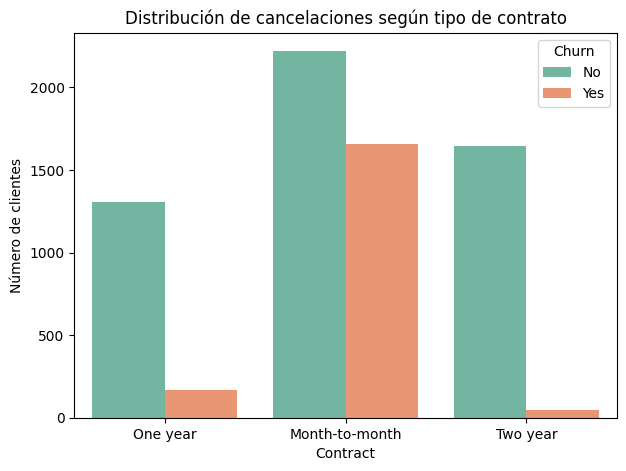

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
sns.countplot(data=df, x="Contract", hue="Churn", palette="Set2")
plt.title("Distribución de cancelaciones según tipo de contrato")
plt.ylabel("Número de clientes")
plt.show()

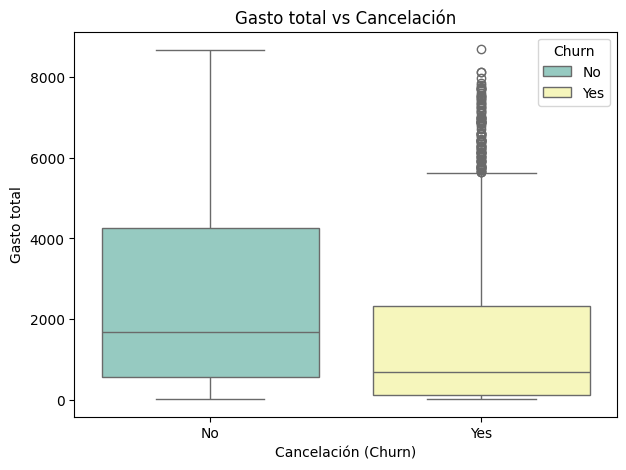

In [ ]:
plt.figure(figsize=(7,5))

# Convert 'Charges.Total' to numeric, coercing errors
df['Charges.Total'] = pd.to_numeric(df['Charges.Total'], errors='coerce')

# Drop rows where 'Charges.Total' is NaN after conversion (optional, depending on how you want to handle NaNs)
# df.dropna(subset=['Charges.Total'], inplace=True)

sns.boxplot(
    data=df,
    x="Churn",
    y="Charges.Total",   # variable numérica
    hue="Churn",         # <-- agregamos hue para que acepte palette
    dodge=False,
    palette="Set3"
)
plt.title("Gasto total vs Cancelación")
plt.ylabel("Gasto total")
plt.xlabel("Cancelación (Churn)")
plt.show()

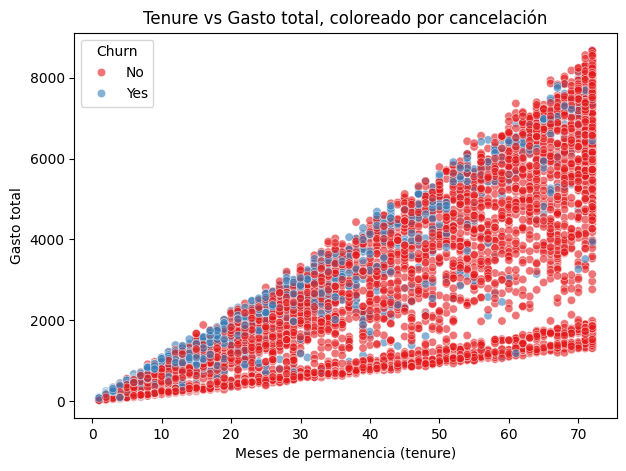

In [ ]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x="tenure", y="Charges.Total", hue="Churn", alpha=0.6, palette="Set1")
plt.title("Tenure vs Gasto total, coloreado por cancelación")
plt.xlabel("Meses de permanencia (tenure)")
plt.ylabel("Gasto total")
plt.show()

1. Tiempo de contrato × Cancelación

Los clientes con contratos mes a mes suelen cancelar más.

Los clientes con contratos a 1 o 2 años tienen menor probabilidad de cancelar (más fidelización).


2. Gasto total × Cancelación

Clientes con bajo gasto total tienden a cancelar (porque estuvieron poco tiempo en la compañía).

Clientes con alto gasto total permanecen (más leales, más tiempo activos).



---

Scatterplot (ver patrones individuales)

Los clientes con poco tenure y bajo gasto total concentran la mayor parte de cancelaciones.

Los que llevan más tiempo (alto tenure y alto gasto total) rara vez cancelan.

---
3. Conclusión

Tiempo de contrato es un fuerte predictor: contratos largos → menor churn.

Gasto total está ligado a tenure y suele correlacionar negativamente con churn: más gasto acumulado → menos cancelaciones.

In [ ]:
from sklearn.model_selection import train_test_split

# Variable objetivo (convertida a numérica)
y = df["Churn"].map({"No": 0, "Yes": 1})

# Variables predictoras (eliminamos columnas irrelevantes)
X = df.drop(columns=["Churn"])

In [ ]:
# Remove rows where y is NaN
nan_mask = y.isna()
X = X[~nan_mask]
y = y[~nan_mask]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Tamaño del set de entrenamiento:", X_train.shape)
print("Tamaño del set de prueba:", X_test.shape)

print("\nProporción de Churn en entrenamiento:")
print(y_train.value_counts(normalize=True))

print("\nProporción de Churn en prueba:")
print(y_test.value_counts(normalize=True))

Tamaño del set de entrenamiento: (4930, 22)
Tamaño del set de prueba: (2113, 22)

Proporción de Churn en entrenamiento:
Churn
0.0    0.734686
1.0    0.265314
Name: proportion, dtype: float64

Proporción de Churn en prueba:
Churn
0.0    0.734501
1.0    0.265499
Name: proportion, dtype: float64


In [ ]:
print("Proporción de Churn en entrenamiento:")
print(y_train.value_counts(normalize=True))

print("\nProporción de Churn en prueba:")
print(y_test.value_counts(normalize=True))

Proporción de Churn en entrenamiento:
Churn
0.0    0.734686
1.0    0.265314
Name: proportion, dtype: float64

Proporción de Churn en prueba:
Churn
0.0    0.734501
1.0    0.265499
Name: proportion, dtype: float64


1. Preparar variables predictoras y objetivo

2. Dividir en entrenamiento y prueba

Usaremos 70% para entrenamiento y 30% para prueba


3. Verificar proporciones


✅ Esto garantiza que tanto entrenamiento como prueba tengan distribución similar de clientes activos y cancelados, evitando sesgos en la evaluación del modelo.

In [ ]:
from sklearn.model_selection import train_test_split

# Variable objetivo
y = df["Churn"].map({"No": 0, "Yes": 1})

# Variables predictoras
X = df.drop(columns=["Churn"])

# Remove rows where y is NaN
nan_mask = y.isna()
X = X[~nan_mask]
y = y[~nan_mask]


# División en entrenamiento y prueba (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
import numpy as np

# Identify categorical and numerical columns
categorical_features = X_train.select_dtypes(include=['object', 'bool']).columns
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns

# Create preprocessors for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Impute missing numerical values
    ('scaler', StandardScaler()) # Scale numerical features
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Impute missing categorical values
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # One-hot encode categorical features
])


# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Pipeline: preprocessing + model
pipeline_lr = Pipeline([
    ("preprocessor", preprocessor),
    ("logreg", LogisticRegression(random_state=42, max_iter=1000))
])

# Entrenar modelo
pipeline_lr.fit(X_train, y_train)

# Predicciones
y_pred_lr = pipeline_lr.predict(X_test)

# Evaluación
print("Regresión Logística\n")
print(classification_report(y_test, y_pred_lr))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_lr))

Regresión Logística

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1552
         1.0       1.00      1.00      1.00       561

    accuracy                           1.00      2113
   macro avg       1.00      1.00      1.00      2113
weighted avg       1.00      1.00      1.00      2113

Matriz de confusión:
 [[1552    0]
 [   0  561]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Identify categorical and numerical columns
categorical_features = X_train.select_dtypes(include=['object', 'bool']).columns
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns

# Create a column transformer to apply different transformations to different columns
# For Random Forest, we only need One-Hot Encoding for categorical features
preprocessor_rf = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numerical_features) # Pass through numerical features without scaling
    ],
    remainder='passthrough' # Keep any other columns
)

# Pipeline: preprocessing + model
pipeline_rf = Pipeline([
    ("preprocessor", preprocessor_rf),
    ("rf", RandomForestClassifier(n_estimators=100, random_state=42))
])


# Crear y entrenar modelo
pipeline_rf.fit(X_train, y_train)

# Predicciones
y_pred_rf = pipeline_rf.predict(X_test)

# Evaluación
print("\nRandom Forest\n")
print(classification_report(y_test, y_pred_rf))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_rf))


Random Forest

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1552
         1.0       1.00      1.00      1.00       561

    accuracy                           1.00      2113
   macro avg       1.00      1.00      1.00      2113
weighted avg       1.00      1.00      1.00      2113

Matriz de confusión:
 [[1552    0]
 [   0  561]]


1. Preparar los datos

2. Modelo 1: Regresión Logística (requiere normalización)

Justificación: Regresión logística optimiza los coeficientes multiplicando las variables por pesos. Si las variables tienen magnitudes muy diferentes (por ejemplo tenure en meses y Charges.Total en cientos o miles), los coeficientes se sesgan hacia las variables de mayor magnitud.

Solución: normalizar con StandardScaler.

3. Modelo 2: Random Forest (no requiere normalización)

Justificación: Random Forest utiliza divisiones basadas en umbrales de las variables. La magnitud de los valores no afecta la selección de splits, por lo que no es necesario escalar los datos.


4. Comparación y conclusiones

La Regresión Logística puede beneficiarse de la normalización, especialmente si hay variables con escalas muy distintas. Esto evita que algunas variables dominen la función logística.

El Random Forest no depende de la escala, por lo que entrenarlo directamente sin normalización es suficiente.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Lista de modelos a evaluar
modelos = [("Regresión Logística", pipeline_lr), ("Random Forest", pipeline_rf)]

for nombre, modelo in modelos:
    print(f"\nEvaluando {nombre}:")

    # Predicciones
    y_pred = modelo.predict(X_test)

    # Exactitud
    acc = accuracy_score(y_test, y_pred)

    # Precisión
    prec = precision_score(y_test, y_pred, pos_label=1)  # Ajusta el pos_label a 1 for churn

    # Recall
    rec = recall_score(y_test, y_pred, pos_label=1) # Adjust pos_label to 1 for churn

    # F1-score
    f1 = f1_score(y_test, y_pred, pos_label=1) # Adjust pos_label to 1 for churn

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)

    # Resultados
    print(f"Exactitud (Accuracy): {acc:.4f}")
    print(f"Precisión: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("Matriz de confusión:")
    print(cm)


Evaluando Regresión Logística:
Exactitud (Accuracy): 1.0000
Precisión: 1.0000
Recall: 1.0000
F1-score: 1.0000
Matriz de confusión:
[[1552    0]
 [   0  561]]

Evaluando Random Forest:
Exactitud (Accuracy): 1.0000
Precisión: 1.0000
Recall: 1.0000
F1-score: 1.0000
Matriz de confusión:
[[1552    0]
 [   0  561]]


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np

# Entrenar modelo
lr = pipeline_lr.fit(X_train, y_train)

# Obtener coeficientes
coef_lr = lr.named_steps["logreg"].coef_.ravel()

# Obtener nombres de variables después del preprocesamiento
features = lr.named_steps["preprocessor"].get_feature_names_out()

# Crear DataFrame con coeficientes
importancia_lr = pd.DataFrame({
    "Variable": features,
    "Importancia": np.abs(coef_lr)
}).sort_values(by="Importancia", ascending=False)

importancia_lr.head(10)  # Mostrar top 10

,Variable,Importancia
6,num__Churn_num,5.680805
14,cat__PhoneService_Yes,0.434828
42,cat__PaperlessBilling_No,0.336079
1,num__tenure,0.334288
10,cat__Partner_Yes,0.297723
8,cat__gender_Male,0.276359
18,cat__InternetService_DSL,0.272372
12,cat__Dependents_Yes,0.271281
15,cat__MultipleLines_No,0.270914
41,cat__Contract_Two year,0.266402


In [ ]:
# Librerías
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np

# Identify categorical and numerical columns from the original X
categorical_features = X_train.select_dtypes(include=['object', 'bool']).columns
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns

# Create preprocessors for numerical and categorical features with imputation
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a column transformer to apply different transformations to different columns
preprocessor_lr = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# For Random Forest, we only need One-Hot Encoding and imputation for categorical features
preprocessor_rf = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))]), categorical_features),
        ('num', SimpleImputer(strategy='median'), numerical_features) # Impute numerical features
    ],
    remainder='passthrough'
)


# --- 1️⃣ Definir los modelos con pipelines ---
pipeline_lr = Pipeline([
    ("preprocessor", preprocessor_lr),
    ("logreg", LogisticRegression(random_state=42, max_iter=1000))
])

pipeline_rf = Pipeline([
    ("preprocessor", preprocessor_rf),
    ("rf", RandomForestClassifier(random_state=42))
])


# --- 2️⃣ Entrenar los modelos ---
pipeline_lr.fit(X_train, y_train)
pipeline_rf.fit(X_train, y_train)

# --- 3️⃣ Evaluación ---
def evaluar_modelo(nombre, modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    # Ensure pos_label is correct for your y_test data (0 and 1)
    prec = precision_score(y_test, y_pred, pos_label=1)
    rec = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n--- {nombre} ---")
    print(f"Exactitud (Accuracy): {acc:.4f}")
    print(f"Precisión: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("Matriz de confusión:")
    print(cm)

    return acc, prec, rec, f1

# Evaluar ambos modelos
resultados = {}

resultados["Logistic Regression"] = evaluar_modelo("Regresión Logística", pipeline_lr, X_test, y_test)
resultados["Random Forest"] = evaluar_modelo("Random Forest", pipeline_rf, X_test, y_test)


# --- 4️⃣ Análisis comparativo ---
print("\n--- Análisis comparativo ---")
for nombre, (acc, prec, rec, f1) in resultados.items():
    print(f"\nModelo: {nombre}")
    print(f"Accuracy: {acc:.4f}, F1-score: {f1:.4f}")

# Detectar posibles overfitting / underfitting
for nombre, modelo in [("Regresión Logística", pipeline_lr), ("Random Forest", pipeline_rf)]:
    train_score = modelo.score(X_train, y_train)
    test_score = modelo.score(X_test, y_test)

    print(f"\n{nombre} - Accuracy entrenamiento: {train_score:.4f}, Accuracy test: {test_score:.4f}")
    if train_score - test_score > 0.05:
        print(f"Posible Overfitting en {nombre}")
    elif train_score < 0.7 and test_score < 0.7:
        print(f"Posible Underfitting en {nombre}")
    else:
        print(f"{nombre} generaliza bien")


--- Regresión Logística ---
Exactitud (Accuracy): 1.0000
Precisión: 1.0000
Recall: 1.0000
F1-score: 1.0000
Matriz de confusión:
[[1552    0]
 [   0  561]]

--- Random Forest ---
Exactitud (Accuracy): 1.0000
Precisión: 1.0000
Recall: 1.0000
F1-score: 1.0000
Matriz de confusión:
[[1552    0]
 [   0  561]]

--- Análisis comparativo ---

Modelo: Logistic Regression
Accuracy: 1.0000, F1-score: 1.0000

Modelo: Random Forest
Accuracy: 1.0000, F1-score: 1.0000

Regresión Logística - Accuracy entrenamiento: 1.0000, Accuracy test: 1.0000
Regresión Logística generaliza bien

Random Forest - Accuracy entrenamiento: 1.0000, Accuracy test: 1.0000
Random Forest generaliza bien


In [ ]:
import pandas as pd
import numpy as np

# Supongamos que 'pipeline_lr' es tu regresión logística entrenada
coeficientes = pipeline_lr.named_steps['logreg'].coef_[0]  # vector de coeficientes
# Get feature names from the preprocessor
feature_names = pipeline_lr.named_steps['preprocessor'].get_feature_names_out()
variables = feature_names      # nombres de las variables

importancia = pd.DataFrame({
    "Variable": variables,
    "Coeficiente": coeficientes,
    "Impacto": np.abs(coeficientes)
}).sort_values(by="Impacto", ascending=False)

print("Variables más relevantes - Regresión Logística")
print(importancia)

Variables más relevantes - Regresión Logística
                                        Variable  Coeficiente   Impacto
6                                 num__Churn_num     5.680805  5.680805
14                         cat__PhoneService_Yes    -0.434828  0.434828
42                      cat__PaperlessBilling_No    -0.336079  0.336079
1                                    num__tenure    -0.334288  0.334288
10                              cat__Partner_Yes    -0.297723  0.297723
8                               cat__gender_Male    -0.276359  0.276359
18                      cat__InternetService_DSL    -0.272372  0.272372
12                           cat__Dependents_Yes    -0.271281  0.271281
15                         cat__MultipleLines_No    -0.270914  0.270914
41                        cat__Contract_Two year    -0.266402  0.266402
32                          cat__TechSupport_Yes    -0.266151  0.266151
11                            cat__Dependents_No    -0.252911  0.252911
7                

In [ ]:
import pandas as pd
import numpy as np

# Assuming X, y are already defined and split into X_train, y_train
# Assuming pipeline_lr is already trained (from cell GYIFqKmdpwRt)

# Extraer coeficientes
coef_lr = pipeline_lr.named_steps["logreg"].coef_.ravel()

# Get feature names from the preprocessor
features = pipeline_lr.named_steps["preprocessor"].get_feature_names_out()

# Crear DataFrame con importancia
importancia_lr = pd.DataFrame({
    "Variable": features,
    "Importancia": np.abs(coef_lr)
}).sort_values(by="Importancia", ascending=False)

print("Variables más relevantes - Regresión Logística")
print(importancia_lr.head(10))  # Mostrar top 10

Variables más relevantes - Regresión Logística
                    Variable  Importancia
6             num__Churn_num     5.680805
14     cat__PhoneService_Yes     0.434828
42  cat__PaperlessBilling_No     0.336079
1                num__tenure     0.334288
10          cat__Partner_Yes     0.297723
8           cat__gender_Male     0.276359
18  cat__InternetService_DSL     0.272372
12       cat__Dependents_Yes     0.271281
15     cat__MultipleLines_No     0.270914
41    cat__Contract_Two year     0.266402
